# Неявное решение уравнения фильтрации однофазной жидкости в двухмерном пласте

Муравцев Александр. Вариант 16

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sympy.matrices import Matrix

## Задание значений входных параметров и перевод единиц измерения в СИ

In [2]:
mesh_x_count = 4  # количество ячеек по пространству в направлении оси Ox
mesh_y_count = 4  # количество ячеек по пространству в направлении оси Oy
mesh_t_count = 5  # количество шагов по времени

In [3]:
dt = 10  # сут, временной шаг
dt *= 24 * 60 * 60  # с, временной шаг

m = 0.18  # пористость

mu = 4  # мПа*с, вязкость жидкости
mu *= 1e-3  # Па*с, вязкость жидкости

k = np.array([
    [30.0, 30.0, 30.0, 30.0],
    [30.0, 40.0, 40.0, 40.0],
    [30.0, 40.0, 40.0, 50.0],
    [30.0, 40.0, 50.0, 40.0]
])  # мД, проницаемость
k *= 1e-3 * (1e-6) ** 2  # м^2, проницаемость

dx = 100  # м, ширина ячейки по оси Ox
dy = 100  # м, ширина ячейки по оси Oy

h = 50  # м, толщина пласта

b_liq = 1  # м^3/м^3, объёмный коэффициент жидкости

compr = 2.2e-9  # Па^(-1), общая сжимаемость

p_initial = 20  # МПа, начальное пластовое давление
p_initial *= 1e6  # Па, начальное пластовое давление

q_inj = 40  # м^3/сут, расход нагнетательной скважины в поверхностных условиях
q_inj /= (24 * 60 * 60)  # м^3/с, расход нагнетательной скважины в поверхностных условиях

q_prod = 40  # м^3/сут, дебит добывающей скважины в поверхностных условиях
q_prod /= (24 * 60 * 60)  # м^3/с, дебит добывающей скважины в поверхностных условиях

In [4]:
# безразмерные множители, входящие в формулы неяного метода
gamma = (m * mu * compr / k) * (dx ** 2 / dt)
beta = (dx / dy) ** 2

## Запись конечно-разностного уравнения

Конечно-разностное уравнение 2D-фильтрации:

$$\frac{P_{i+1,j}^{t+\Delta t}-2P_{i,j}^{t+\Delta t}+P_{i-1,j}^{t+\Delta t}}{\left(\Delta x\right)^2}+\frac{P_{i, j+1}^{t+\Delta t}-2P_{i,j}^{t+\Delta t}+P_{i,j-1}^{t+\Delta t}}{\left(\Delta y\right)^2}=\left(\frac{m\mu c}{k_{i,j}}\right)\frac{P_{i,j}^{t+\Delta t}-P_{i,j}^{t}}{\Delta t}$$

Приведём подобные и перепишем в следующем виде:

$$e_{i,j}P_{i,j-1}^{t+\Delta t}+a_{i,j}P_{i-1,j}^{t+\Delta t}+b_{i,j}P_{i,j}^{t+\Delta t}+c_{i,j}P_{i+1,j}^{t+\Delta t}+f_{i,j}P_{i,j+1}^{t+\Delta t}=d_{i,j},$$

где $e_{i,j}=\beta$; $a_{i,j}=1$; $b_{i,j}=-2-2\beta-\gamma_{i,j}$; $c_{i,j}=1$; $f_{i,j}=\beta$; $d_{i,j}=-\gamma_{i,j} P_{i,j}^t$; 

$\beta=\left(\dfrac{\Delta x}{\Delta y}\right)^2$; $\gamma_{i,j}=\left(\dfrac{m\mu c}{k_{i,j}}\right)\dfrac{\left(\Delta x\right)^2}{\Delta t}$

Коэффициенты получены для всех ячеек за исключением граничных ячеек и за исключением ячеек со скважинами.

## Матрица системы и левые части уравнений в символьном виде

In [5]:
cells_numbering = Matrix([[0, 1, 2, 3], [4, 5, 6, 7], [8, 9, 10, 11], [12, 13, 14, 15]])


square_matrix = Matrix(
    [['b_00', 'f_00', 0, 0, 'c_00', 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
     ['e_01', 'b_01', 'f_01', 0, 0, 'c_01', 0, 0 ,0 ,0 ,0 ,0 ,0 ,0, 0, 0],
     [0, 'e_02', 'b_02', 'f_02', 0, 0, 'c_02', 0, 0, 0, 0, 0, 0, 0, 0, 0],
     [0 ,0, 'e_03', 'b_03', 'f_03', 0, 0, 'c_03', 0, 0, 0, 0, 0, 0, 0, 0],
     ['a_10', 0, 0, 'e_10', 'b_10', 'f_10', 0, 0, 'c_10', 0, 0, 0, 0, 0, 0, 0],
     [0, 'a_11', 0, 0, 'e_11', 'b_11', 'f_11', 0, 0, 'c_11', 0, 0, 0, 0, 0, 0],
     [0, 0, 'a_12', 0, 0, 'e_12', 'b_12', 'f_12', 0, 0, 'c_12', 0, 0, 0, 0, 0],
     [0, 0, 0, 'a_13', 0, 0, 'e_13', 'b_13', 'f_13', 0, 0, 'c_13', 0, 0, 0, 0],
     [0, 0, 0, 0, 'a_20', 0, 0, 'e_20', 'b_20', 'f_20', 0, 0, 'c_20', 0, 0, 0],
     [0, 0, 0, 0, 0, 'a_21', 0, 0, 'e_21', 'b_21', 'f_21', 0, 0, 'c_21', 0, 0],
     [0 ,0, 0, 0, 0, 0, 'a_22', 0, 0, 'e_22', 'b_22', 'f_22', 0, 0, 'c_22', 0],
     [0, 0, 0, 0, 0, 0, 0, 'a_23', 0, 0, 'e_23', 'b_23', 'f_23', 0, 0, 'c_23'],
     [0, 0, 0, 0, 0, 0, 0, 0, 'a_30', 0, 0, 'e_30', 'b_30', 'f_30', 0, 0],
     [0, 0, 0, 0, 0, 0, 0, 0, 0, 'a_31', 0, 0, 'e_31', 'b_31', 'f_31', 0],
     [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 'a_32', 0, 0, 'e_32', 'b_32', 'f_32'],
     [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 'a_33', 0, 0, 'e_33', 'b_33'],
     ]
)
        
pressures_vector = Matrix(
    [['P_00'], ['P_01'], ['P_02'], ['P_03'],
     ['P_10'], ['P_11'], ['P_12'], ['P_13'],
     ['P_20'], ['P_21'], ['P_22'], ['P_23'],
     ['P_30'], ['P_31'], ['P_32'], ['P_33']]
)

print('Нумерация ячеек пласта:')
display(cells_numbering)
print('Матрица СЛАУ:')
display(square_matrix)
print('Левая часть СЛАУ (после перемножения матрицы на столбец):')
display(square_matrix * pressures_vector)

Нумерация ячеек пласта:


Matrix([
[ 0,  1,  2,  3],
[ 4,  5,  6,  7],
[ 8,  9, 10, 11],
[12, 13, 14, 15]])

Матрица СЛАУ:


Matrix([
[b_00, f_00,    0,    0, c_00,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0],
[e_01, b_01, f_01,    0,    0, c_01,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0],
[   0, e_02, b_02, f_02,    0,    0, c_02,    0,    0,    0,    0,    0,    0,    0,    0,    0],
[   0,    0, e_03, b_03, f_03,    0,    0, c_03,    0,    0,    0,    0,    0,    0,    0,    0],
[a_10,    0,    0, e_10, b_10, f_10,    0,    0, c_10,    0,    0,    0,    0,    0,    0,    0],
[   0, a_11,    0,    0, e_11, b_11, f_11,    0,    0, c_11,    0,    0,    0,    0,    0,    0],
[   0,    0, a_12,    0,    0, e_12, b_12, f_12,    0,    0, c_12,    0,    0,    0,    0,    0],
[   0,    0,    0, a_13,    0,    0, e_13, b_13, f_13,    0,    0, c_13,    0,    0,    0,    0],
[   0,    0,    0,    0, a_20,    0,    0, e_20, b_20, f_20,    0,    0, c_20,    0,    0,    0],
[   0,    0,    0,    0,    0, a_21,    0,    0, e_21, b_21, f_21,    0,    0, c_21,    0,    0],
[   0,    0

Левая часть СЛАУ (после перемножения матрицы на столбец):


Matrix([
[                        P_00*b_00 + P_01*f_00 + P_10*c_00],
[            P_00*e_01 + P_01*b_01 + P_02*f_01 + P_11*c_01],
[            P_01*e_02 + P_02*b_02 + P_03*f_02 + P_12*c_02],
[            P_02*e_03 + P_03*b_03 + P_10*f_03 + P_13*c_03],
[P_00*a_10 + P_03*e_10 + P_10*b_10 + P_11*f_10 + P_20*c_10],
[P_01*a_11 + P_10*e_11 + P_11*b_11 + P_12*f_11 + P_21*c_11],
[P_02*a_12 + P_11*e_12 + P_12*b_12 + P_13*f_12 + P_22*c_12],
[P_03*a_13 + P_12*e_13 + P_13*b_13 + P_20*f_13 + P_23*c_13],
[P_10*a_20 + P_13*e_20 + P_20*b_20 + P_21*f_20 + P_30*c_20],
[P_11*a_21 + P_20*e_21 + P_21*b_21 + P_22*f_21 + P_31*c_21],
[P_12*a_22 + P_21*e_22 + P_22*b_22 + P_23*f_22 + P_32*c_22],
[P_13*a_23 + P_22*e_23 + P_23*b_23 + P_30*f_23 + P_33*c_23],
[            P_20*a_30 + P_23*e_30 + P_30*b_30 + P_31*f_30],
[            P_21*a_31 + P_30*e_31 + P_31*b_31 + P_32*f_31],
[            P_22*a_32 + P_31*e_32 + P_32*b_32 + P_33*f_32],
[                        P_23*a_33 + P_32*e_33 + P_33*b_33]])

## Запись граничных условий на скважинах

Для добывающей скважины:

$$\frac{P_{0,2}^{t+\Delta t}-P_{0,3}^{t+\Delta t}}{\left(\Delta x\right)^2}+\frac{P_{1,3}^{t+\Delta t}-P_{0,3}^{t+\Delta t}}{\left(\Delta y\right)^2}-Q_{prod}\frac{\mu}{\Delta x\cdot A\cdot k_{0,3}}=\left(\dfrac{m\mu c}{k_{0,3}}\right)\frac{P_{0,3}^{t+\Delta t}-P_{0,3}^{t}}{\Delta t}$$

домножим на $\left(\Delta x\right)^2$:

$$P_{0,2}^{t+\Delta t}-P_{0,3}^{t+\Delta t}+\beta\left(P_{1,3}^{t+\Delta t}-P_{0,3}^{t+\Delta t}\right)-Q_{prod}\frac{\mu}{h\cdot k_{0,3}}=\gamma_{0,3}\left(P_{0,3}^{t+\Delta t}-P_{0,3}^{t}\right)$$

Таким образом, $e_{0,3}=1$; $a_{0,3}=0$; $b_{0,3}=-1-\beta-\gamma_{0,3}$; $c_{0,3}=\beta$; $f_{0,3}=0$; $d_{0,3}=-\gamma_{0,3}P_{0,3}^{t}+Q_{prod}\dfrac{\mu}{h\cdot k_{0,3}}$

---

Для нагнетательной скважины:

$$\frac{P_{3,1}^{t+\Delta t}-P_{3,0}^{t+\Delta t}}{\left(\Delta x\right)^2}+\frac{P_{2,0}^{t+\Delta t}-P_{3,0}^{t+\Delta t}}{\left(\Delta y\right)^2}+Q_{inj}\frac{\mu}{\Delta x\cdot A\cdot k_{3,0}}=\left(\dfrac{m\mu c}{k_{3,0}}\right)\frac{P_{3,0}^{t+\Delta t}-P_{3,0}^{t}}{\Delta t}$$

домножим на $\left(\Delta x\right)^2$:

$$P_{3,1}^{t+\Delta t}-P_{3,0}^{t+\Delta t}+\beta\left(P_{2,0}^{t+\Delta t}-P_{3,0}^{t+\Delta t}\right)+Q_{inj}\frac{\mu}{h\cdot k_{3,0}}=\gamma_{3,0}\left(P_{3,0}^{t+\Delta t}-P_{3,0}^{t}\right)$$

Таким образом, $e_{3,0}=0$; $a_{3,0}=\beta$; $b_{3,0}=-1-\beta-\gamma_{3,0}$; $c_{3,0}=0$; $f_{3,0}=1$; $d_{3,0}=-\gamma_{3,0}P_{3,0}^{t}-Q_{inj}\dfrac{\mu}{h\cdot k_{3,0}}$

---

Далее эти коэффициенты будут прописаны в коде (в ячейках с соответствующими скважинами)

## Задание начальных и граничных условий. Решение системы

In [6]:
# список, в который будут добавляться поля давлений на каждом временном шаге
p = []
p.append(np.full((mesh_x_count, mesh_y_count), p_initial))

In [7]:
for time_step in range(mesh_t_count):
    
    system_matrix = np.zeros((mesh_x_count * mesh_y_count, mesh_x_count * mesh_y_count))
    d = np.zeros(mesh_x_count * mesh_y_count)

    # базовые условия из уравнения пьезопроводности, записанном в конечно-разностном виде
    for i in range(mesh_x_count):
        for j in range(mesh_x_count):
            system_matrix[i * mesh_x_count + j, i * mesh_x_count + j] = -2 - 2 * beta - gamma[i, j]
            d[i * mesh_x_count + j] = -gamma[i, j] * p[-1][i, j] 
    system_matrix += np.diag([beta] * (mesh_x_count * mesh_y_count - 1), k=-1)
    system_matrix += np.diag([beta] * (mesh_x_count * mesh_y_count - 1), k=1)
    system_matrix += np.diag([1] * (mesh_y_count * mesh_x_count - mesh_x_count), k=mesh_x_count)
    system_matrix += np.diag([1] * (mesh_y_count * mesh_x_count - mesh_x_count), k=-mesh_x_count)

    # условия, устраняющие связь последних ячеек в ряду с первой ячейкой в следующем ряду
    system_matrix[3, 4] = 0
    system_matrix[4, 3] = 0
    system_matrix[7, 8] = 0
    system_matrix[8, 7] = 0
    system_matrix[11, 12] = 0
    system_matrix[12, 11] = 0

    # ГУ в ячейке 3 (добывающая скважина) -- при нумерации ячеек с нуля
    system_matrix[3, 2] = 1
    system_matrix[3, 3] = -1 - beta - gamma[0, 3]
    system_matrix[3, 7] = beta
    system_matrix[3, 4] = 0
    d[3] = -gamma[0, 3] * p[-1][0, 3] + q_prod * mu / (h * k[0, 3])

    # ГУ в ячейке 12 (нагнетательная скважина) -- при нумерации ячеек с нуля
    system_matrix[12, 11] = 0
    system_matrix[12, 8] = 1
    system_matrix[12, 12] = -1 - beta - gamma[3, 0]
    system_matrix[12, 13] = beta
    d[12] = -gamma[3, 0] * p[-1][3, 0] - q_inj * mu / (h * k[3, 0])

    # решение системы
    p.append(np.linalg.solve(system_matrix, d).reshape(mesh_x_count, mesh_y_count))

# Вывод результатов

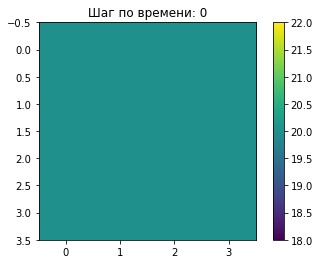

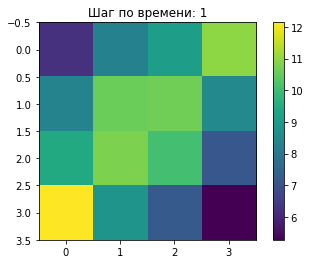

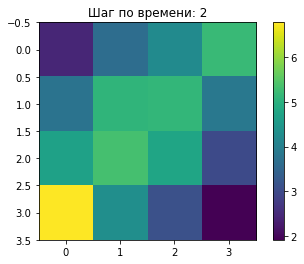

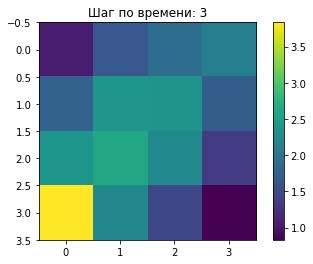

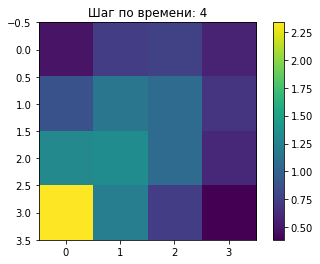

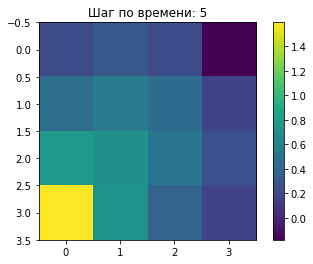

In [8]:
for i, field in enumerate(p):
    plt.figure()
    plt.title(f'Шаг по времени: {i}')
    plt.imshow(field / 1e6)
    plt.colorbar()

# Неудавшаяся попытка поставить условия неперетока

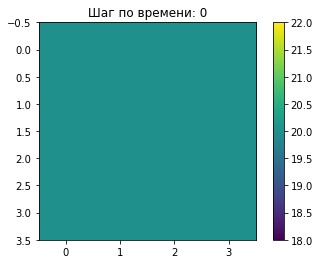

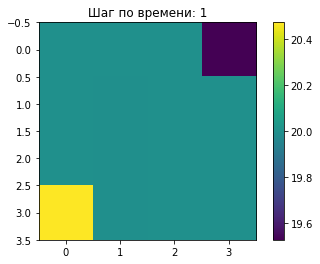

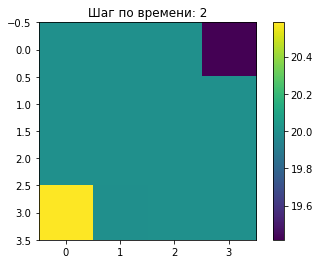

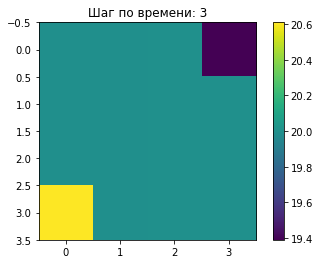

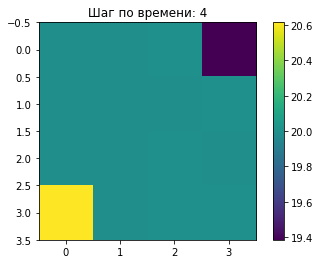

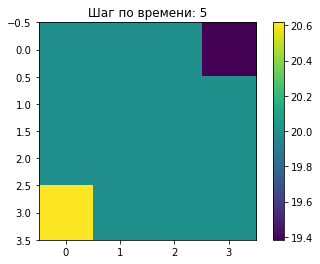

In [9]:
# список, в который будут добавляться поля давлений на каждом временном шаге
p = []
p.append(np.full((mesh_x_count, mesh_y_count), p_initial))


for time_step in range(mesh_t_count):
    
    system_matrix = np.zeros((mesh_x_count * mesh_y_count, mesh_x_count * mesh_y_count))
    d = np.zeros(mesh_x_count * mesh_y_count)

    # базовые условия из уравнения пьезопроводности, записанном в конечно-разностном виде
    for i in range(mesh_x_count):
        for j in range(mesh_x_count):
            system_matrix[i * mesh_x_count + j, i * mesh_x_count + j] = -2 - 2 * beta - gamma[i, j]
            d[i * mesh_x_count + j] = -gamma[i, j] * p[-1][i, j] 
    system_matrix += np.diag([beta] * (mesh_x_count * mesh_y_count - 1), k=-1)
    system_matrix += np.diag([beta] * (mesh_x_count * mesh_y_count - 1), k=1)
    system_matrix += np.diag([1] * (mesh_y_count * mesh_x_count - mesh_x_count), k=mesh_x_count)
    system_matrix += np.diag([1] * (mesh_y_count * mesh_x_count - mesh_x_count), k=-mesh_x_count)

    # условия, устраняющие связь последних ячеек в ряду с первой ячейкой в следующем ряду
    system_matrix[3, 4] = 0
    system_matrix[4, 3] = 0
    system_matrix[7, 8] = 0
    system_matrix[8, 7] = 0
    system_matrix[11, 12] = 0
    system_matrix[12, 11] = 0

    # ГУ в ячейке 3 (добывающая скважина) -- при нумерации ячеек с нуля
    system_matrix[3, 2] = 1
    system_matrix[3, 3] = -1 - beta - gamma[0, 3]
    system_matrix[3, 7] = beta
    system_matrix[3, 4] = 0
    d[3] = -gamma[0, 3] * p[-1][0, 3] + q_prod * mu / (h * k[0, 3])

    # ГУ в ячейке 12 (нагнетательная скважина) -- при нумерации ячеек с нуля
    system_matrix[12, 11] = 0
    system_matrix[12, 8] = 1
    system_matrix[12, 12] = -1 - beta - gamma[3, 0]
    system_matrix[12, 13] = beta
    d[12] = -gamma[3, 0] * p[-1][3, 0] - q_inj * mu / (h * k[3, 0])

    
    # ГУ в ячейке 1 (условие неперетока)
    system_matrix[1, 0] = 0
    system_matrix[1, 1] = -1 - gamma[0, 1]
    system_matrix[1, 5] = 1
    system_matrix[1, 2] = 0

    # ГУ в ячейке 2 (условие неперетока)
    system_matrix[2, 1] = 0
    system_matrix[2, 2] = -1 - gamma[0, 2]
    system_matrix[2, 6] = 1
    system_matrix[2, 3] = 0

    # ГУ в ячейке 13 (условие неперетока)
    system_matrix[13, 12] = 0
    system_matrix[13, 9] = 1
    system_matrix[13, 13] = -1 - gamma[3, 1]
    system_matrix[13, 14] = 0

    # ГУ в ячейке 14 (условие неперетока)
    system_matrix[14, 13] = 0
    system_matrix[14, 10] = 1
    system_matrix[14, 14] = -1 - gamma[3, 2]
    system_matrix[14, 15] = 0

    # ГУ в ячейке 0 (условие неперетока)
    system_matrix[0, 0] = -1 - beta - gamma[0, 0]
    system_matrix[0, 4] = 1
    system_matrix[0, 1] = beta

    # ГУ в ячейке 15 (условие неперетока)
    system_matrix[15, 14] = beta
    system_matrix[15, 11] = 1
    system_matrix[15, 15] = -1 - beta - gamma[3, 3]

    # ГУ в ячейке 4 (условие неперетока)
    system_matrix[4, 3] = 0
    system_matrix[4, 0] = 0
    system_matrix[4, 4] = -1 - gamma[1, 0] / beta
    system_matrix[4, 8] = 0
    system_matrix[4, 5] = 1

    # ГУ в ячейке 8 (условие неперетока)
    system_matrix[8, 7] = 0
    system_matrix[8, 4] = 0
    system_matrix[8, 8] = -1 - gamma[2, 0] / beta
    system_matrix[8, 12] = 0
    system_matrix[8, 9] = 1

    # ГУ в ячейке 7 (условие неперетока)
    system_matrix[7, 6] = 1
    system_matrix[7, 3] = 0
    system_matrix[7, 7] = -1 - gamma[1, 3] / beta
    system_matrix[7, 11] = 0
    system_matrix[7, 8] = 0

    # ГУ в ячейке 11 (условие неперетока)
    system_matrix[11, 10] = 1
    system_matrix[11, 7] = 0
    system_matrix[11, 11] = -1 - gamma[2, 3] / beta
    system_matrix[11, 15] = 0
    system_matrix[11, 12] = 0
    
    # решение системы
    p.append(np.linalg.solve(system_matrix, d).reshape(mesh_x_count, mesh_y_count))

for i, field in enumerate(p):
    plt.figure()
    plt.title(f'Шаг по времени: {i}')
    plt.imshow(field / 1e6)
    plt.colorbar()
    plt.show()